# Churned Users Modelling


The output of a predictive churn model is a measure of the immediate or future risk of a customer cancellation,in this case whether the customer will withdraw money from their Robinhood account

*use cases*
- to understand why customers are leaving 
- to provide incentives to certain customers to prevent them from leaving
- predicting the revenue of the business

## a) Churned percentage
A user is considered churned when their account balance falls below $10 for 28 consecutive calendar days

**Dataset** 

equity_value_data: only users when account balance >=$10

**Limitation and Assumptions 1: observation window** 

User can churn and reactivate. Tenured users are more likely to churn and reactivate, while new users , since the observation window is short, there is not enough time for them to reactivate after churn.

For this 1-year  truncated data, we don't know the first active day of each user, therefore each user has a different observation window. Take an extreme case, all users boarded within 27 days from last day of the truncated data (e.g. onboard in Aug 2017)will be defined as no-churn, which is unfair for those users boarded in Aug 2016.

Assume the boarded date is the first record in equity_value_data. We can see 99.5% of users were boarded in and before Mar 2017, which gives at least 4 months observation window to define churn (maintaining low balance for 28 days). The 4 users boarded in Aug 2017 and 7 users boarded in Jul 2017 do not have a 28- day observation window. Total 11 accounts have a minimum impact on overall churn rate.

**Limitation and Assumptions 2: churn and reactivate** 

If a user once churn and reactivate, the definition is not clear.
There are two ways to simplify it:

- a) as long as the user once churned, the user is considered as churned

- b) only if the user has been deactivated for 28 days as of the most recent day, which is the next day of latest date in data (Aug 19, 2018), the user is considered as churned

There are in total 5,584 users in the data.

**By definition a**:
There are 1,007 users who have churned history, the rest 4,577 users have never deactivated for >=28 days.

- **churn rate = 1007/5584 =18.03%**

**By definition b**:
There are 813 users who are churned as of Aug 19, 2018, the rest 4771 are active as of Aug 19, 2018, although they may have been churned before, but now they are active. 

- **churn rate = 813 /5584 =14.56%**

The difference of 194 accounts (20% of total users with churned history) is really the gray area.

**definition a** is not perfect , because users can be churned for many other reasons (for example promotions by competitors) but they will come back and continue doing transactions at Robinhood. Therefore from a business point of view they are not churned.

**definition b** solved the problem that if a user churned but returned, we won't count it as churned .  However it is not a perfect solution either, because tenured users(10-12months) have unfair comparison than new users(5-9 months) because maybe those  new users(5-9 months)  will be churned in a couple of months later. 

For simple purpose, let us go for definition a, the churn rate is 18.03%

## b) Classifier  
**Final model used simple logistic regression with woe transformation without regularization**  

Other benchmark models used here is 
1. Logistic regression with regularization
2. Decision Tree
3. Neural Network


- Usually model performance ranking is  GBM > random forest> BAGGING / Neural NetWork  > Logistic >Decision Tree
- **Since the purpose of this project is to understand why users churn, for simplicity and explanatory, I won't choose GBM or random forest as the classifier,and I will use decision tree and logistic regression for classification. At the same time, I will use neural network as benchmark**   
- **Since logistic performance is similar to neural network, and better than decision tree, logistic regression is my final model**

**function used**
- Data visualization
- WOE transformation
- Grid search / cross validation
- OneHotEncoder
- log transformation


**performance metrics AUC and KS**

|                            | AUC      | KS       |
| :-------------------------:| :------: | :------: |
| LogisticRegression         | 0.6866   | 0.2970   |
| DecisionTree + GridSearch  | 0.6304   | 0.2004   |
| NeuralNetwork + GridSearch | 0.6888   | 0.2891   |

- Best classifier : LogisticRegression 
- **train_data_reg.probability** and **test_data_reg.probability** are the assigned probability in **Cell 58** in below jupyter notebook  
- If probability is **>= 0.204129**, it is predicted as **churned**  
- This probability has **max separation power between churned and non-churned (max KS in training sample)**
- This probability can **capture 56% churned users** in test sample (true positive rate /recall), impacting **32% of non-churned users**(false positive rate/ 1- specificity)
- **train_data_out.csv** and **test_data_out.csv** are files containing assigned probability and predicted churned indicator  



## c) Feature importance

### There are 6 catagorical variables and 2 numerical variables and the trend summary is as below:  

**1. risk_tolerance**: lower risk tolerance, higher churn rate  
**2. investment_experience**: no expeience, higher churn rate  
**3. liquidity_needs**: somewhat > no_important > very_important  
**4. platform**: android > ios > both  
**5. instrument_type_first_traded**:  mlp(20% churn rate) > stock(18.5%) >reit(16%) >adr(14%)>etp (13%)  
**6. time_horizon**: short time > long or med time  
**7. time_spent**: higher time spent, higher churn  
**8. first_deposit_amount**: lower deposit, higher churn rate  


|Importance Ranking| LogisticRegression         | Decision Tree              |GradientBoosting           |
| :---------------:| :------------------------: | :------------------------: |:------------------------: |
| 1                | first_deposit_amount       | first_deposit_amount       |time_spent                 |
| 2                | time_spent                 | time_spent                 |first_deposit_amount       |
| 3                | risk_tolerance             | time_horizon               |risk_tolerance             |
| 4                | time_horizon               | risk_tolerance             |time_horizon               |
| 5                | liquidity_needs            | instrument                 |instrument                 |
| 6                | instrument(drop)           | liquidity_needs(drop)      |liquidity_needs            |
| 7                | investment_experience(drop)| investment_experience(drop)|platform(drop)             |
| 8                | platform   (drop)          | platform(drop)             |investment_experience(drop)|

**Note:(drop) means statistically insignificant in above table**  

**In Summary**,
1. first_deposit_amount and time_spent are very important
2. risk_tolerance, time horizon and liquidity_needs are important
3. instrument itself is not predictive, some levels e.g. "reit" are important to some extent, however the sample size is very small, so we cannot really tell 
4. investment_experience and platform are not correlated to churn, which is consistent across all analyzing method (Information value analysis, Logistic regression, Tree-based method)  




### Load equity_value_data and define churn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
churn = pd.read_csv("equity_value_data.csv")

### Data quality

timestamp       0
close_equity    0
user_id         0
dtype: int64
10.0
2016-08-16 00:00:00+00:00
2017-08-18 00:00:00+00:00


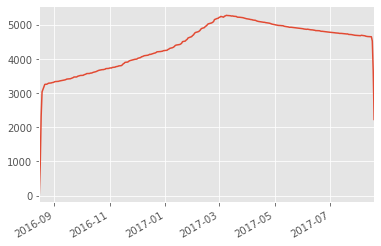

In [2]:
pd.to_datetime(churn.timestamp).value_counts().plot()
print(churn.isnull().sum()) 
print(churn.close_equity.min()) 
print(pd.to_datetime(churn.timestamp).min()) 
print(pd.to_datetime(churn.timestamp).max()) 

- Even if for the first two days and last two days , the number of active users are extremely low and seems abnormal, it will have minimal impact on churn rate estimation
- There is no null value

/Users/makun/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/Users/makun/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


2016-08    3335
2016-09     252
2016-10     242
2016-11     307
2016-12     276
2017-01     452
2017-02     535
2017-03     162
2017-04       2
2017-05       7
2017-06       3
2017-07       7
2017-08       4
Freq: M, Name: (timestamp, min), dtype: int64


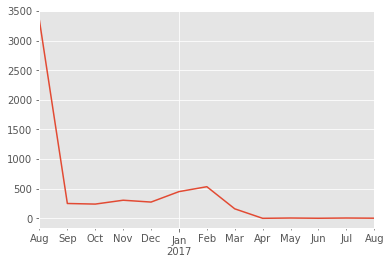

In [3]:
grouped = churn.groupby(['user_id']).agg({'timestamp':['min']}).reset_index()
grouped.sort_values([('timestamp', 'min')], ascending=True)
pd.to_datetime(grouped[('timestamp', 'min')]  ).dt.to_period('M').value_counts().sort_index().plot()
print(pd.to_datetime(grouped[('timestamp', 'min')]  ).dt.to_period('M').value_counts().sort_index())


- We can see 99.5% of users were boarded in and before Mar 2017, which gives at least 4 months of observation window to define churn (maintaining low balance for 28 days). The 4 users boarded in Aug 2017 and 7 users boarded in Jul 2017 do not have a 28- day observation window. The total 11 accounts have a minimum impact on overall churn rate

### Define churn
when their account balance falls below $10 for 28 consecutive calendar days

In [4]:
from datetime import datetime, timedelta
churn['next_timestamp'] = churn.sort_values(by=['timestamp'], ascending=True)\
                       .groupby(['user_id'])['timestamp'].shift(-1)   

churn.next_timestamp_fillna  = churn.next_timestamp.fillna(value=  
     (pd.to_datetime(churn.timestamp.max())+  timedelta(days=1)))
                                                                       
churn['churn_days'] = pd.to_datetime(churn.next_timestamp_fillna,utc=True ) - pd.to_datetime(churn.timestamp,utc=True )

churn['churn_status']= churn.churn_days.map(lambda x:"churn" if x.days>=28 else "stay")

user_churn =pd.crosstab(churn.user_id,churn.churn_status).rename_axis('user_id').reset_index()
user_churn['sum1'] = user_churn.sum(1)
user_churn["churn_ind1"]=user_churn.churn.map(lambda x: 0 if x==0 else 1)

print(user_churn.churn_ind1.value_counts() ) 

/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


0    4577
1    1007
Name: churn_ind1, dtype: int64


In [5]:
churn_last  =churn[churn.next_timestamp.isnull()]
churn_last['churn_most']  =churn_last.timestamp.map(lambda x: "churn" 
                        if pd.to_datetime(x)<=(pd.to_datetime('2017-08-18T00:00:00Z') -   timedelta(days=27))
                                               else "active")
churn_df =pd.crosstab(churn_last.user_id,churn_last.churn_most).rename_axis('user_id').reset_index()
churn_df['sum1'] = churn_df.sum(1)
churn_df["churn_ind1"]=churn_df.churn.map(lambda x: 0 if x==0 else 1)
print(churn_df.churn_ind1.value_counts() )  


0    4771
1     813
Name: churn_ind1, dtype: int64


/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df = user_churn[["user_id","churn_ind1" ]].rename(columns={'churn_ind1': 'churn_ind1_alay'})
df = df.join(churn_df[["user_id","churn_ind1"]].set_index('user_id'), on='user_id')
swap_df =pd.crosstab(df["churn_ind1_alay"],df["churn_ind1"]) 
swap_df['sum1'] = swap_df.sum(1)
swap_df
 

churn_ind1,0,1,sum1
churn_ind1_alay,,,
0,4577,0,4577
1,194,813,1007


There are in total 5,584 users in the data.

**By definition a**:
There are 1,007 users who have churned history, the rest 4,577 users have never deactivated for >=28 days.

- churn rate = 1007/5584 =18.03%

**By definition b**:
There are 813 users who are churned as of Aug 19, 2018, the rest 4771 are active as of Aug 19, 2018, although they may have been churned before, but now they are active. 

- churn rate = 813 /5584 =14.56%

The difference of 194 accounts (20% of total users) is really the gray area.

**definition a** is not perfect , because users can be churned for many other reasons (for example promotions by competitors) but they will come back and continue doing transactions. Therefore from a business point of view they are not churned.

**definition b** solved the problem that if a user churned but returned, we won't count it as churned .  However it is not a perfect solution either, because tenured users(10-12months) have unfair comparison than new users(5-9 months) because maybe those  new users(5-9 months)  will be churned in a couple of months later. 

For simple purpose, let us go for definition a, the churn rate is 18.03%


## Load features_data and build classifier

In [7]:
features = pd.read_csv("features_data.csv" )

0    4577
1    1007
Name: churn_ind1, dtype: int64
0


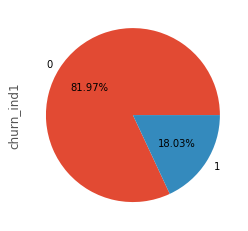

In [8]:
data = user_churn
data = data.join(features.set_index('user_id'), on='user_id', how ='outer')
print(data.churn_ind1.value_counts() ) 
print(data.churn_ind1.isnull().sum())# there is no user_id not existing in the other table
churn_flag = data['churn_ind1']
data['churn_ind1'].value_counts().plot(kind='pie',autopct='%.2f%%')

In [9]:
data.isnull().sum()

user_id                         0
churn                           0
stay                            0
sum1                            0
churn_ind1                      0
risk_tolerance                  0
investment_experience           0
liquidity_needs                 0
platform                        0
time_spent                      0
instrument_type_first_traded    0
first_deposit_amount            0
time_horizon                    0
dtype: int64

### Describetive Analysis / Visualization

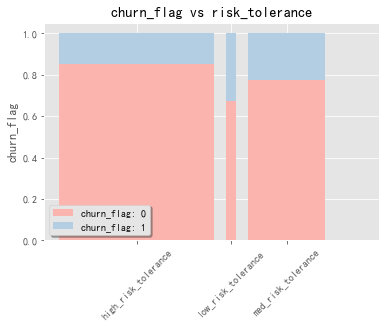

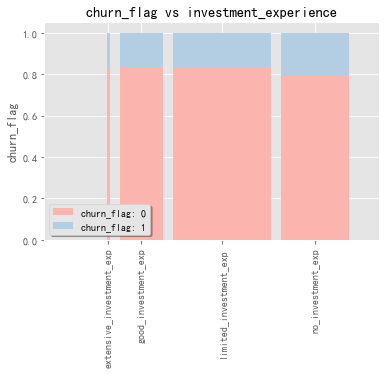

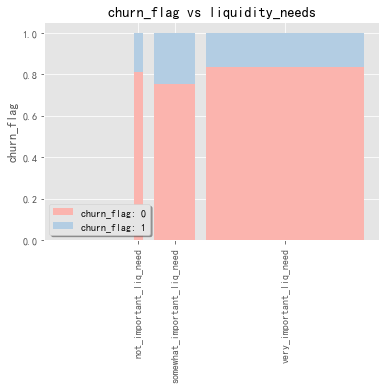

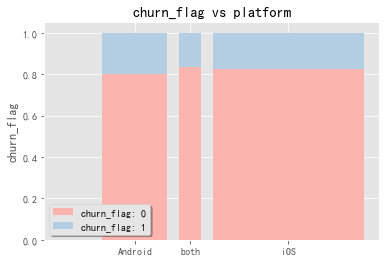

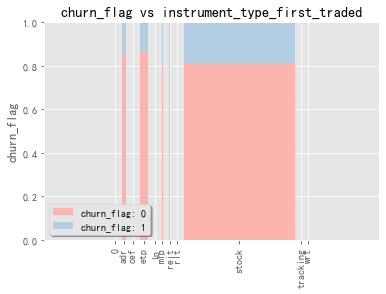

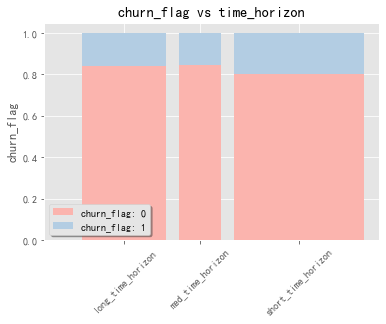

In [10]:
data["churn_flag"] = data['churn_ind1']
from stack2dim import * 
stack2dim(data, i="risk_tolerance", j="churn_flag", rotation=45, location='lower left') 
stack2dim(data, i="investment_experience", j="churn_flag",rotation=90, location='lower left')
stack2dim(data, i="liquidity_needs", j="churn_flag", rotation=90, location='lower left') 
stack2dim(data, i="platform", j="churn_flag",rotation=0, location='lower left')
stack2dim(data, i="instrument_type_first_traded", j="churn_flag", rotation=90, location='lower left') 
stack2dim(data, i="time_horizon", j="churn_flag",rotation=45, location='lower left')


/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


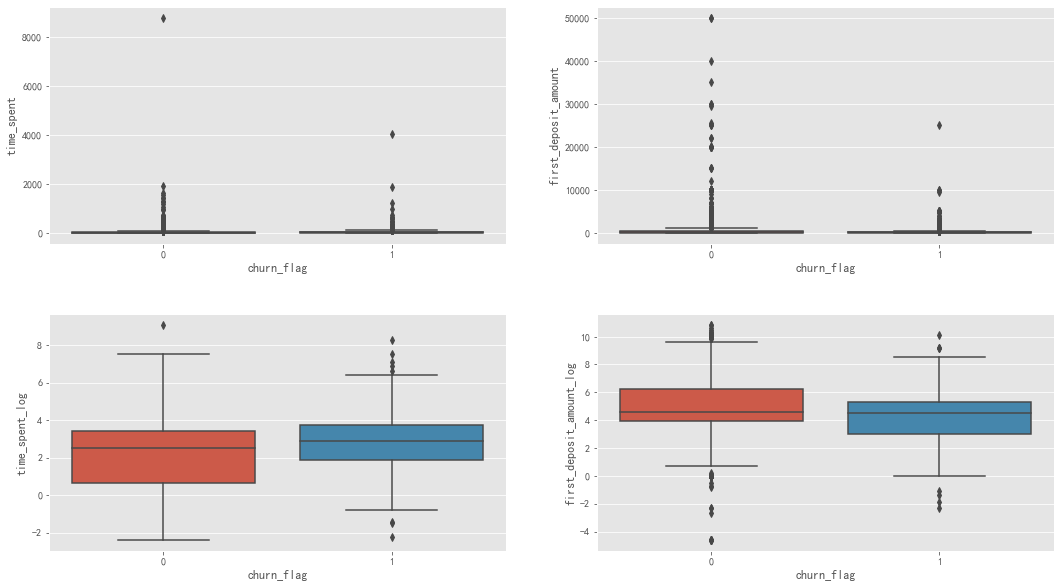

In [11]:
import seaborn as sns 
fig2 = plt.figure(figsize=(18, 10))
fig2.subplots_adjust(hspace=0.3)
ax1 = fig2.add_subplot(2,2,1)
ax2 = fig2.add_subplot(2,2,2)
ax3 = fig2.add_subplot(2,2,3)
ax4 = fig2.add_subplot(2,2,4)
data['time_spent_log'] = np.log(data['time_spent'] )
data['first_deposit_amount_log'] = np.log(data['first_deposit_amount'] )
sns.boxplot(x = 'churn_flag', y = 'time_spent', data = data,ax=ax1) 
sns.boxplot(x = 'churn_flag', y = 'first_deposit_amount', data = data,ax=ax2) 
sns.boxplot(x = 'churn_flag', y = 'time_spent_log', data = data,ax=ax3) 
sns.boxplot(x = 'churn_flag', y = 'first_deposit_amount_log', data = data,ax=ax4) 

### There are 6 catagorical variables and 2 numerical variables 
- There is no missing /null value, which is good
- For catagorical variables , if we look at the stacked bar plot, the height is the churn percent within each level, and the width is the number of users within each level
- For numerical variables, since all the two variables "time" and "amount" is highly right skewed, taking the log transformation and check the boxplot help to analyze the trend
- The trend summary is as below:  
    **1. risk_tolerance**: lower risk tolerance, higher churn rate  
    **2. investment_experience**: no expeience, higher churn rate  
    **3. liquidity_needs**: somewhat > no_important > very_important  
    **4. platform**: android > ios > both, probabily correlated to wealth  
    **5. instrument_type_first_traded**: sample size >30, mlp(20%) > stock(18.5%) >reit(16%) >adr(14%)>etp (13%)  
    **6. time_horizon**: short time > long or med time  
    **7. time_spent**: higher time spent, higher churn  
    **8. first_deposit_amount**: lower deposit, higher churn rate   

### Binning Variables to reasonable level

In [12]:
def risk_tolerance(x):
    if x =="low_risk_tolerance":
        return 1
    elif x =="med_risk_tolerance":
        return 2
    else:
        return 3
data["risk_tolerance_bin"] = data.risk_tolerance.map(risk_tolerance)
print(data.groupby(['risk_tolerance_bin','risk_tolerance']).agg({'churn_flag': ['count', 'mean' ]}))

                                       churn_flag          
                                            count      mean
risk_tolerance_bin risk_tolerance                          
1                  low_risk_tolerance         239  0.326360
2                  med_risk_tolerance        1779  0.227656
3                  high_risk_tolerance       3566  0.146943


In [13]:
def investment_experience(x):
    if x =="no_investment_exp":
        return 1
    else:
        return 2
data["investment_experience_bin"] = data.investment_experience.map(investment_experience)
print(data.groupby(['investment_experience_bin','investment_experience']).agg({'churn_flag': ['count', 'mean' ]}))

                                                   churn_flag          
                                                        count      mean
investment_experience_bin investment_experience                        
1                         no_investment_exp              1796  0.207127
2                         extensive_investment_exp         76  0.171053
                          good_investment_exp            1134  0.164903
                          limited_investment_exp         2578  0.168735


In [14]:
def liquidity_needs(x):
    if "somewhat" in x:
        return 1
    elif "no" in x:
        return 2
    else:
        return 3
data["liquidity_needs_bin"] = data.liquidity_needs.map(liquidity_needs)
print(data.groupby(['liquidity_needs_bin','liquidity_needs']).agg({'churn_flag': ['count', 'mean' ]}))

                                                churn_flag          
                                                     count      mean
liquidity_needs_bin liquidity_needs                                 
1                   somewhat_important_liq_need       1109  0.245266
2                   not_important_liq_need             258  0.189922
3                   very_important_liq_need           4217  0.162675


In [15]:
def platform(x):
    if "Andr" in x:
        return 1
    elif "iOS" in x:
        return 2
    else:
        return 3
data["platform_bin"] = data.platform.map(platform)
print(data.groupby(['platform_bin','platform']).agg({'churn_flag': ['count', 'mean' ]}))

                      churn_flag          
                           count      mean
platform_bin platform                     
1            Android        1529  0.200785
2            iOS            3550  0.173521
3            both            505  0.166337


In [16]:
def platform1(x):
    if "Andr" in x:
        return 1
    else:
        return 2
data["platform_bin1"] = data.platform.map(platform1)
print(data.groupby(['platform_bin1','platform']).agg({'churn_flag': ['count', 'mean' ]}))

                       churn_flag          
                            count      mean
platform_bin1 platform                     
1             Android        1529  0.200785
2             both            505  0.166337
              iOS            3550  0.173521


In [17]:
def time_horizon(x):
    if "shor" in x:
        return 1
    else:
        return 2
data["time_horizon_bin"] = data.time_horizon.map(time_horizon)
print(data.groupby(['time_horizon_bin','time_horizon']).agg({'churn_flag': ['count', 'mean' ]}))

                                    churn_flag          
                                         count      mean
time_horizon_bin time_horizon                           
1                short_time_horizon       2833  0.200847
2                long_time_horizon        1833  0.160393
                 med_time_horizon          918  0.156863


In [18]:
def instrument(x):
    if x =="stock":
        return 2
    elif x =="adr" :
        return 3
    elif x =="etp":
        return 4
    else:
        return 1
data["instrument_bin"] = data.instrument_type_first_traded.map(instrument)
print(data['churn_flag'].groupby(data['instrument_bin']).agg(['count', 'mean'])) 
print(data.groupby(['instrument_bin','instrument_type_first_traded']).agg({'churn_flag': ['count', 'mean' ]}))

                count      mean
instrument_bin                 
1                 177  0.192090
2                4827  0.185208
3                 197  0.142132
4                 383  0.133159
                                            churn_flag          
                                                 count      mean
instrument_bin instrument_type_first_traded                     
1              0                                    13  0.076923
               cef                                  20  0.150000
               lp                                    8  0.375000
               mlp                                  55  0.200000
               reit                                 55  0.163636
               rlt                                   9  0.222222
               tracking                              1  0.000000
               wrt                                  16  0.312500
2              stock                              4827  0.185208
3              adr          

In [19]:
def instrument1(x):
    if x =="adr" or x =="etp":
        return 2
    else:
        return 1
data["instrument_bin1"] = data.instrument_type_first_traded.map(instrument1)
print(data['churn_flag'].groupby(data['instrument_bin1']).agg(['count', 'mean'])) 
print(data.groupby(['instrument_bin1','instrument_type_first_traded']).agg({'churn_flag': ['count', 'mean' ]}))

                 count      mean
instrument_bin1                 
1                 5004  0.185452
2                  580  0.136207
                                             churn_flag          
                                                  count      mean
instrument_bin1 instrument_type_first_traded                     
1               0                                    13  0.076923
                cef                                  20  0.150000
                lp                                    8  0.375000
                mlp                                  55  0.200000
                reit                                 55  0.163636
                rlt                                   9  0.222222
                stock                              4827  0.185208
                tracking                              1  0.000000
                wrt                                  16  0.312500
2               adr                                 197  0.142132
          

In [20]:
bins1 = [-0.01, 0, 1,2 ,3,4,5,6, 10,15, 20,25,30,35,40,50,70,80,90,100,9000]
data['time_spent_bin'] = pd.cut(data.time_spent,bins1)   
print(data['churn_flag'].groupby(data['time_spent_bin']).agg(['count', 'mean'])) 

                 count      mean
time_spent_bin                  
(-0.01, 0.0]      1079  0.078777
(0.0, 1.0]          81  0.148148
(1.0, 2.0]         122  0.245902
(2.0, 3.0]         140  0.221429
(3.0, 4.0]         130  0.184615
(4.0, 5.0]         138  0.166667
(5.0, 6.0]         136  0.191176
(6.0, 10.0]        538  0.178439
(10.0, 15.0]       593  0.185497
(15.0, 20.0]       468  0.185897
(20.0, 25.0]       355  0.216901
(25.0, 30.0]       250  0.180000
(30.0, 35.0]       211  0.222749
(35.0, 40.0]       182  0.236264
(40.0, 50.0]       271  0.214022
(50.0, 70.0]       351  0.222222
(70.0, 80.0]        98  0.183673
(80.0, 90.0]        75  0.253333
(90.0, 100.0]       56  0.339286
(100.0, 9000.0]    310  0.254839


In [21]:
bins1 = [-0.01, 0, 1,3, 20,80,9000]
data['time_spent_bin_cat'] = pd.cut(data.time_spent,bins1)
data['time_spent_bin'] = pd.cut(data.time_spent,bins1, labels=False)  
print(data['churn_flag'].groupby(data['time_spent_bin']).agg(['count', 'mean'])) 
bins1_d = [-0.01, 1,9000]
data['time_spent_dummy1'] = pd.cut(data.time_spent,bins1_d)
data['time_spent_dummy'] = pd.cut(data.time_spent,bins1_d, labels=False)
print(data['churn_flag'].groupby(data['time_spent_dummy']).agg(['count', 'mean'])) 

print(data.groupby(['time_spent_bin','time_spent_bin_cat','time_spent_dummy1']).agg({'churn_flag': ['count', 'mean' ]}))

                count      mean
time_spent_bin                 
0                1079  0.078777
1                  81  0.148148
2                 262  0.232824
3                2003  0.182726
4                1718  0.213038
5                 441  0.265306
                  count      mean
time_spent_dummy                 
0                  1160  0.083621
1                  4424  0.205696
                                                    churn_flag          
                                                         count      mean
time_spent_bin time_spent_bin_cat time_spent_dummy1                     
0              (-0.01, 0.0]       (-0.01, 1.0]            1079  0.078777
1              (0.0, 1.0]         (-0.01, 1.0]              81  0.148148
2              (1.0, 3.0]         (1.0, 9000.0]            262  0.232824
3              (3.0, 20.0]        (1.0, 9000.0]           2003  0.182726
4              (20.0, 80.0]       (1.0, 9000.0]           1718  0.213038
5              (80.0, 90

- **It looks like the trend for time spent is U Shape, 3-20 has lowest churn rate , 1-3 and 20-high have higher churn rate**  
- **It looks like there are some abnormal value 0 and 0-1, these two groups have very low churn rate, and the reason is not clear and need further investigation** 

In [22]:
bins4 = [-0.01, 9,  49, 99,499,9999,50000]
data['first_deposit_amount_bin_cat'] = pd.cut(data.first_deposit_amount,bins4).values.add_categories('missing')
data['first_deposit_amount_bin_cat'].fillna('missing')  
data['first_deposit_amount_bin'] = pd.cut(data.first_deposit_amount,bins4,labels= False)

print(data['churn_flag'].groupby(data['first_deposit_amount_bin']).agg(['count', 'mean'])) 
print(data.groupby(['first_deposit_amount_bin','first_deposit_amount_bin_cat']).agg({'churn_flag': ['count', 'mean' ]}))

                          count      mean
first_deposit_amount_bin                 
0                           273  0.329670
1                          1039  0.259865
2                           697  0.209469
3                          1884  0.169321
4                          1638  0.109280
5                            53  0.056604
                                                      churn_flag          
                                                           count      mean
first_deposit_amount_bin first_deposit_amount_bin_cat                     
0                        (-0.01, 9.0]                        273  0.329670
1                        (9.0, 49.0]                        1039  0.259865
2                        (49.0, 99.0]                        697  0.209469
3                        (99.0, 499.0]                      1884  0.169321
4                        (499.0, 9999.0]                    1638  0.109280
5                        (9999.0, 50000.0]                    53

### Train models , variable selection and model selection

In [23]:
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import ensemble
import matplotlib.pyplot as plt
trainData, testData = train_test_split(data, train_size=0.7,random_state=42)
print(trainData.churn_flag.value_counts())

trainData.to_csv('trainData.csv',index=False)
testData.to_csv('testData.csv',index=False)

0    3201
1     707
Name: churn_flag, dtype: int64


#### Decision tree

In [24]:
import sklearn.model_selection as cross_validation
bin_var = ['first_deposit_amount_bin','liquidity_needs_bin', 'time_horizon_bin' ,\
           'risk_tolerance_bin', 'investment_experience_bin',\
           'time_spent_bin','time_spent_dummy',\
           'instrument_bin','instrument_bin1',\
           'platform_bin','platform_bin1']
num_feature = ['time_spent','first_deposit_amount']
all_feature = bin_var[:]
all_feature.extend(['risk_tolerance','investment_experience','liquidity_needs','platform',\
                    'instrument_type_first_traded','time_horizon'])
all_feature.extend(num_feature)
train_data = trainData[all_feature] 
test_data =  testData[all_feature] 
train_target = trainData["churn_flag"] 
test_target = testData["churn_flag"] 


In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_transformer =make_column_transformer(
(OneHotEncoder(handle_unknown ='ignore'),['risk_tolerance','investment_experience','liquidity_needs',\
                                          'platform','instrument_type_first_traded','time_horizon'] ),   
)
ohe = column_transformer.fit_transform(train_data)
col_names = column_transformer.named_transformers_['onehotencoder'].get_feature_names()
ohe_df = pd.DataFrame(ohe.toarray(), columns = col_names) 
ohe_df.index = train_data.index
train_data =  trainData[bin_var+num_feature].join(ohe_df)

ohe_test = column_transformer.transform(test_data)
ohe_test_df = pd.DataFrame(ohe_test.toarray(), columns = col_names) 
ohe_test_df.index = test_data.index
test_data =  testData[bin_var+num_feature].join(ohe_test_df)

train_data["first_deposit_amount_log"] = train_data.first_deposit_amount.map(lambda x: np.log(x+0.01))
test_data["first_deposit_amount_log"] = test_data.first_deposit_amount.map(lambda x: np.log(x+0.01))


train_data["time_spent_log"] = train_data.time_spent.map(lambda x: np.log(x+0.01))
test_data["time_spent_log"] = test_data.time_spent.map(lambda x: np.log(x+0.01))

model_features = train_data.columns.values.tolist()
model_features


['first_deposit_amount_bin',
 'liquidity_needs_bin',
 'time_horizon_bin',
 'risk_tolerance_bin',
 'investment_experience_bin',
 'time_spent_bin',
 'time_spent_dummy',
 'instrument_bin',
 'instrument_bin1',
 'platform_bin',
 'platform_bin1',
 'time_spent',
 'first_deposit_amount',
 'x0_high_risk_tolerance',
 'x0_low_risk_tolerance',
 'x0_med_risk_tolerance',
 'x1_extensive_investment_exp',
 'x1_good_investment_exp',
 'x1_limited_investment_exp',
 'x1_no_investment_exp',
 'x2_not_important_liq_need',
 'x2_somewhat_important_liq_need',
 'x2_very_important_liq_need',
 'x3_Android',
 'x3_both',
 'x3_iOS',
 'x4_0',
 'x4_adr',
 'x4_cef',
 'x4_etp',
 'x4_lp',
 'x4_mlp',
 'x4_reit',
 'x4_rlt',
 'x4_stock',
 'x4_tracking',
 'x4_wrt',
 'x5_long_time_horizon',
 'x5_med_time_horizon',
 'x5_short_time_horizon',
 'first_deposit_amount_log',
 'time_spent_log']

In [26]:
import sklearn.tree as tree
# Any random parameter
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2)  
clf.fit(train_data, train_target)   

train_est = clf.predict(train_data)  
train_est_p=clf.predict_proba(train_data)[:,1]  # This is the probability of churn for training data
test_est=clf.predict(test_data)  
test_est_p=clf.predict_proba(test_data)[:,1]  #  # This is the probability of churn for test data


## Evaluation
import sklearn.metrics as metrics

print(metrics.confusion_matrix(test_target, test_est,labels=[0,1]))   
print(metrics.classification_report(test_target, test_est))   
print(pd.DataFrame(list(zip(train_data.columns, clf.feature_importances_)),columns=["columns","importance"]).sort_values(by='importance', ascending=False)) 


[[1361   15]
 [ 297    3]]
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1376
           1       0.17      0.01      0.02       300

    accuracy                           0.81      1676
   macro avg       0.49      0.50      0.46      1676
weighted avg       0.70      0.81      0.74      1676

                           columns  importance
11                      time_spent    0.268254
12            first_deposit_amount    0.223359
40        first_deposit_amount_log    0.144813
41                  time_spent_log    0.070787
39           x5_short_time_horizon    0.051058
34                        x4_stock    0.038287
37            x5_long_time_horizon    0.029620
3               risk_tolerance_bin    0.028766
32                         x4_reit    0.028322
16     x1_extensive_investment_exp    0.021049
27                          x4_adr    0.021018
13          x0_high_risk_tolerance    0.017695
25                          x3_iOS 

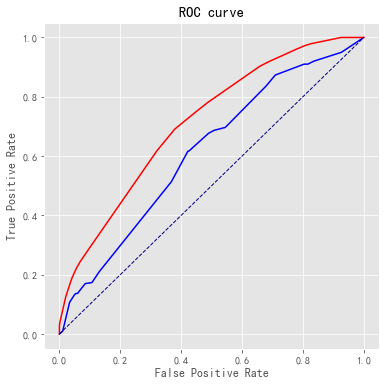

Train AUC = 0.7126
Test AUC = 0.6135
[[1361   15]
 [ 297    3]]
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1376
           1       0.17      0.01      0.02       300

    accuracy                           0.81      1676
   macro avg       0.49      0.50      0.46      1676
weighted avg       0.70      0.81      0.74      1676



In [27]:
# roc to check overfitting
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color='blue')#blue :test
plt.plot(fpr_train, tpr_train, color='red')#red : train
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# severe overfitting
print('Train AUC = %6.4f' %metrics.auc(fpr_train, tpr_train)) 
print('Test AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))  
print(metrics.confusion_matrix(test_target, test_est,labels=[0,1]))  
print(metrics.classification_report(test_target, test_est))   
 

In [28]:
### Calculate the KS for the  model
def KS(df, score, target):
    '''
    :param df: the dataset containing probability and bad indicator
    :param score:
    :param target:
    :return:
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all.index = range(len(all))
    all = all.sort_values(by=score,ascending=False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    all['totalPcnt'] = all['total'] / all['total'].sum()
    KS = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    return  max(KS)


In [29]:
compare_train=pd.DataFrame({'train_target':train_target,'train_est':train_est,'train_est_p':train_est_p})
compare_test=pd.DataFrame({'test_target':test_target,'test_est':test_est,'test_est_p':test_est_p})
print('Train KS = %6.4f' %KS(compare_train, 'train_est_p', 'train_target')) 
print('Test KS = %6.4f' %KS(compare_test, 'test_est_p', 'test_target')) 

Train KS = 0.3119
Test KS = 0.1944


- Decision tree is overfitting, however AUC and KS both tell the prediction power is not high
- standards are KS >=0.3 , AUC>=0.7

#### Decision tree + Grid Search

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


param_grid = {
    'criterion':['entropy','gini'],
    'max_depth':[3,4,5,6,7], 
    'min_samples_split':[2,3,4,5,6,7] 
}
clf = tree.DecisionTreeClassifier() 
 
clfcv = GridSearchCV(estimator=clf, param_grid=param_grid, 
                   scoring='roc_auc', cv=4) 
clfcv.fit(train_data, train_target)
 
clfcv.best_params_ 

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}

In [31]:
importace = clfcv.best_estimator_.feature_importances_.tolist()
featureImportance = zip(model_features,importace)
featureImportanceSorted = sorted(featureImportance, key=lambda k: k[1],reverse=True)
featureImportanceSorted

[('first_deposit_amount', 0.2976178038955655),
 ('time_spent_log', 0.2467195803768492),
 ('first_deposit_amount_log', 0.18600134825380113),
 ('time_horizon_bin', 0.08212807186972684),
 ('x5_long_time_horizon', 0.04764474422257305),
 ('risk_tolerance_bin', 0.046270809130403566),
 ('x4_reit', 0.04555631062278788),
 ('time_spent', 0.030367694695978782),
 ('x4_lp', 0.017693636932313975),
 ('first_deposit_amount_bin', 0.0),
 ('liquidity_needs_bin', 0.0),
 ('investment_experience_bin', 0.0),
 ('time_spent_bin', 0.0),
 ('time_spent_dummy', 0.0),
 ('instrument_bin', 0.0),
 ('instrument_bin1', 0.0),
 ('platform_bin', 0.0),
 ('platform_bin1', 0.0),
 ('x0_high_risk_tolerance', 0.0),
 ('x0_low_risk_tolerance', 0.0),
 ('x0_med_risk_tolerance', 0.0),
 ('x1_extensive_investment_exp', 0.0),
 ('x1_good_investment_exp', 0.0),
 ('x1_limited_investment_exp', 0.0),
 ('x1_no_investment_exp', 0.0),
 ('x2_not_important_liq_need', 0.0),
 ('x2_somewhat_important_liq_need', 0.0),
 ('x2_very_important_liq_need', 

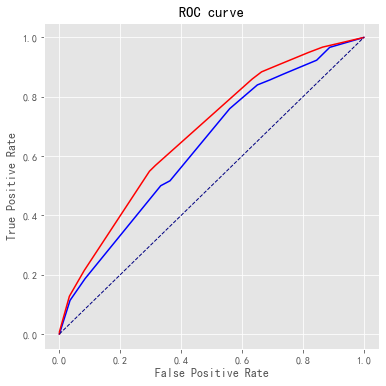

Train AUC = 0.6760
Test AUC = 0.6304
Train KS = 0.2531
Test KS = 0.2004
[[1376    0]
 [ 300    0]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1376
           1       0.00      0.00      0.00       300

    accuracy                           0.82      1676
   macro avg       0.41      0.50      0.45      1676
weighted avg       0.67      0.82      0.74      1676



/Users/makun/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
train_est = clfcv.predict(train_data)   
train_est_p = clfcv.predict_proba(train_data)[:,1]   
test_est = clfcv.predict(test_data)  
test_est_p = clfcv.predict_proba(test_data)[:,1]  

# roc to check overfitting
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color='blue')#blue :test
plt.plot(fpr_train, tpr_train, color='red')#red : train
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# some overfitting
print('Train AUC = %6.4f' %metrics.auc(fpr_train, tpr_train))  
print('Test AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))  
compare_train=pd.DataFrame({'train_target':train_target,'train_est':train_est,'train_est_p':train_est_p})
compare_test=pd.DataFrame({'test_target':test_target,'test_est':test_est,'test_est_p':test_est_p})
print('Train KS = %6.4f' %KS(compare_train, 'train_est_p', 'train_target')) 
print('Test KS = %6.4f' %KS(compare_test, 'test_est_p', 'test_target')) 
print(metrics.confusion_matrix(test_target, test_est,labels=[0,1]))  
print(metrics.classification_report(test_target, test_est))   
 

- Decision tree after Grid Search is some overfitting, however AUC and KS both tell the prediction power is not high
- standards are KS >=0.3 , AUC>=0.7

#### neural network

In [33]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(train_data)

scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)


from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes':[(15, ),(5, 5),(4, 8),(5, 6)],
    'activation':['logistic', 'tanh', 'relu'], 
    'alpha':[0.001, 0.01, 0.1, 0.2, 0.4, 1, 10]
}
mlp = MLPClassifier(max_iter=1000)
gcv = GridSearchCV(estimator=mlp, param_grid=param_grid, 
                   scoring='roc_auc', cv=4, n_jobs=-1)
gcv.fit(scaled_train_data, train_target)

gcv.best_params_
 

{'activation': 'tanh', 'alpha': 0.2, 'hidden_layer_sizes': (4, 8)}

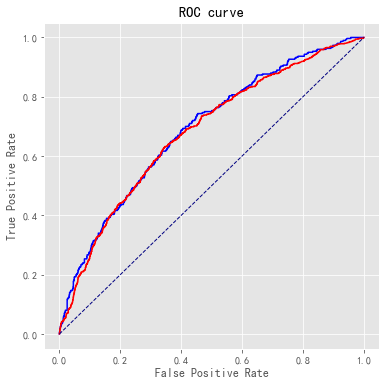

Train AUC = 0.6800
Test AUC = 0.6888
Train KS = 0.2855
Test KS = 0.2891
[[1374    2]
 [ 297    3]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1376
           1       0.60      0.01      0.02       300

    accuracy                           0.82      1676
   macro avg       0.71      0.50      0.46      1676
weighted avg       0.78      0.82      0.74      1676



In [34]:

train_est = gcv.predict(scaled_train_data)   
train_est_p=gcv.predict_proba(scaled_train_data)[:,1]   
test_est=gcv.predict(scaled_test_data)  
test_est_p=gcv.predict_proba(scaled_test_data)[:,1]   

fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color='blue')#blue :test
plt.plot(fpr_train, tpr_train, color='red')#red : train
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# not overfitting
print('Train AUC = %6.4f' %metrics.auc(fpr_train, tpr_train)) 
print('Test AUC = %6.4f' %metrics.auc(fpr_test, tpr_test)) 
compare_train=pd.DataFrame({'train_target':train_target,'train_est':train_est,'train_est_p':train_est_p})
compare_test=pd.DataFrame({'test_target':test_target,'test_est':test_est,'test_est_p':test_est_p})
print('Train KS = %6.4f' %KS(compare_train, 'train_est_p', 'train_target')) 
print('Test KS = %6.4f' %KS(compare_test, 'test_est_p', 'test_target')) 

print(metrics.confusion_matrix(test_target, test_est,labels=[0,1]))  
print(metrics.classification_report(test_target, test_est))   
 

- Neural network after Grid Search is not overfitting, and better than decision tree
- However AUC and KS both tell the prediction power is not high. Standards are KS >=0.3 , AUC>=0.7

### Logistic Regression 
- Lasso 
- WOE transaformation

In [35]:


def CalcWOE(df, col, target):
    '''
    :param df: dataframe containing feature and target
    :param col: the feature that needs to be calculated the WOE and iv, usually categorical type
    :param target: good/bad indicator
    :return: WOE and IV in a dictionary
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict, 'IV':IV}


In [36]:

train_data_reg = train_data 
train_data_reg["churn_flag"] = trainData["churn_flag"]

test_data_reg =  test_data 
test_data_reg["churn_flag"]=testData["churn_flag"]

train_target = trainData["churn_flag"]
test_target = testData["churn_flag"]


WOE_IV_dict={}
allFeatures = []

bin_var = ['first_deposit_amount_bin','liquidity_needs_bin', 'time_horizon_bin' ,\
           'risk_tolerance_bin', 'investment_experience_bin',\
           'time_spent_bin','time_spent_dummy',\
           'instrument_bin','instrument_bin1',\
           'platform_bin','platform_bin1']

for var in bin_var:
    WOE_IV_dict[var] = CalcWOE(train_data_reg, var, 'churn_flag')


WOE_IV_dict 

{'first_deposit_amount_bin': {'WOE': {0: -0.7923480809229735,
   1: -0.4864768935782983,
   2: -0.10854794327873919,
   3: 0.020356095891146925,
   4: 0.6323060643469285,
   5: 1.1047719039629078},
  'IV': 0.19479104902121827},
 'liquidity_needs_bin': {'WOE': {1: -0.34703706426760955,
   2: 0.011651979042824253,
   3: 0.10045898470994886},
  'IV': 0.033361339050725254},
 'time_horizon_bin': {'WOE': {1: -0.1785381896992233, 2: 0.20246059350222848},
  'IV': 0.036038457538597135},
 'risk_tolerance_bin': {'WOE': {1: -0.755347124508005,
   2: -0.25900760176691295,
   3: 0.2141710061191563},
  'IV': 0.08137170016371344},
 'investment_experience_bin': {'WOE': {1: -0.14951067732369996,
   2: 0.07632253371710544},
  'IV': 0.0114001960706828},
 'time_spent_bin': {'WOE': {0: 0.8676206401583428,
   1: 0.23901198073596877,
   2: -0.4041954781075581,
   3: -0.053657633226851256,
   4: -0.1573694421497892,
   5: -0.4031721746088012},
  'IV': 0.1416527509948748},
 'time_spent_dummy': {'WOE': {0: 0.814

In [37]:
#   Single variable IV  #
#  Chose IV > 0.02 
low_IV =[(k, v['IV']) for k, v in WOE_IV_dict.items() if v['IV'] < 0.02]
print(low_IV)
high_IV = [(k,v['IV']) for k,v in WOE_IV_dict.items() if v['IV'] >= 0.02]
high_IV_sorted = sorted(high_IV, key=lambda k: k[1],reverse=True)
high_IV_sorted

[('investment_experience_bin', 0.0114001960706828), ('instrument_bin', 0.013021858884773313), ('instrument_bin1', 0.011619630617250942), ('platform_bin', 0.008007577709847872), ('platform_bin1', 0.007722021561937818)]


[('first_deposit_amount_bin', 0.19479104902121827),
 ('time_spent_bin', 0.1416527509948748),
 ('time_spent_dummy', 0.12402151797854627),
 ('risk_tolerance_bin', 0.08137170016371344),
 ('time_horizon_bin', 0.036038457538597135),
 ('liquidity_needs_bin', 0.033361339050725254)]

In [38]:
for pair in  [(k,v['IV']) for k,v in WOE_IV_dict.items() ]:
    var=pair[0]
    newVar = var+"_WOE"
    train_data_reg[newVar] = train_data_reg[var].map(lambda x: WOE_IV_dict[var]['WOE'][x])


In [39]:
print(train_data_reg.groupby(['investment_experience_bin','investment_experience_bin_WOE']).agg({'churn_flag': ['count', 'mean' ,'sum' ]}))

                                                        churn_flag            \
                                                             count      mean   
investment_experience_bin investment_experience_bin_WOE                        
1                         -0.149511                           1259  0.204130   
2                          0.076323                           2649  0.169875   

                                                              
                                                         sum  
investment_experience_bin investment_experience_bin_WOE       
1                         -0.149511                      257  
2                          0.076323                      450  


#### Using logistic regression with Lasso

In [40]:
bin_var = ['first_deposit_amount_bin','liquidity_needs_bin', 'time_horizon_bin' ,\
           'risk_tolerance_bin', 'investment_experience_bin',\
           'time_spent_bin','time_spent_dummy',\
           'instrument_bin','instrument_bin1',\
           'platform_bin','platform_bin1']
WOE_var = ['first_deposit_amount_bin_WOE','liquidity_needs_bin_WOE', 'time_horizon_bin_WOE' ,\
           'risk_tolerance_bin_WOE', 'investment_experience_bin_WOE',\
           'time_spent_bin_WOE','time_spent_dummy_WOE',\
           'instrument_bin_WOE','instrument_bin1_WOE',\
           'platform_bin_WOE','platform_bin1_WOE']

model_features1 = model_features[:]
model_features1.extend(WOE_var)

train_data = train_data_reg[model_features1]
train_target = train_data_reg["churn_flag"]

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1, fit_intercept=True)
lr.fit(train_data, train_target)
y_train_pred = lr.predict(train_data)


/Users/makun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


                           feature     coeff
14           x0_low_risk_tolerance  0.208958
16     x1_extensive_investment_exp  0.204924
39           x5_short_time_horizon  0.153825
21  x2_somewhat_important_liq_need  0.130950
30                           x4_lp  0.099412
4        investment_experience_bin  0.099321
23                      x3_Android  0.071575
6                 time_spent_dummy  0.065795
34                        x4_stock  0.035988
36                          x4_wrt  0.033117
27                          x4_adr  0.027137
41                  time_spent_log  0.026981
26                            x4_0  0.026188
31                          x4_mlp  0.018580
33                          x4_rlt  0.014291
46   investment_experience_bin_WOE  0.011666
5                   time_spent_bin  0.006784
12            first_deposit_amount -0.000027
11                      time_spent -0.000203
17          x1_good_investment_exp -0.009098
52               platform_bin1_WOE -0.012262
51        

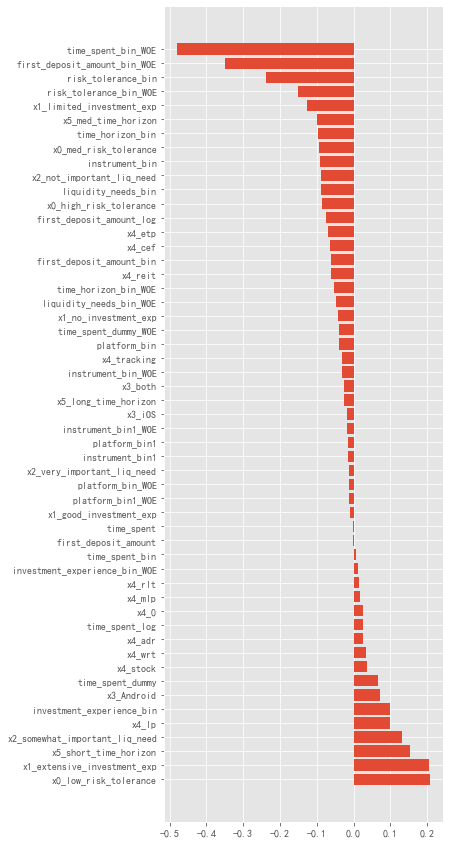

In [41]:
df_coeffs= pd.DataFrame(list(zip(model_features1, lr.coef_.flatten()))).sort_values(by=[1],ascending=False)
df_coeffs.columns=["feature","coeff"]
print(df_coeffs)
f, ax = plt.subplots(figsize=(5,15))
plt.barh(y="feature", width = 'coeff',data=df_coeffs )
t = np.arange(train_data.shape[1])
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.show()

/Users/makun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


                           feature     coeff
41                  time_spent_log  0.071940
39           x5_short_time_horizon  0.024950
14           x0_low_risk_tolerance  0.017725
21  x2_somewhat_important_liq_need  0.011664
15           x0_med_risk_tolerance  0.009442
16     x1_extensive_investment_exp  0.002395
6                 time_spent_dummy  0.001725
5                   time_spent_bin  0.001390
30                           x4_lp  0.000967
36                          x4_wrt  0.000553
46   investment_experience_bin_WOE  0.000169
31                          x4_mlp  0.000164
26                            x4_0  0.000100
33                          x4_rlt  0.000002
12            first_deposit_amount -0.000055
11                      time_spent -0.000246
35                     x4_tracking -0.000293
23                      x3_Android -0.000495
52               platform_bin1_WOE -0.000799
51                platform_bin_WOE -0.000854
28                          x4_cef -0.000989
32        

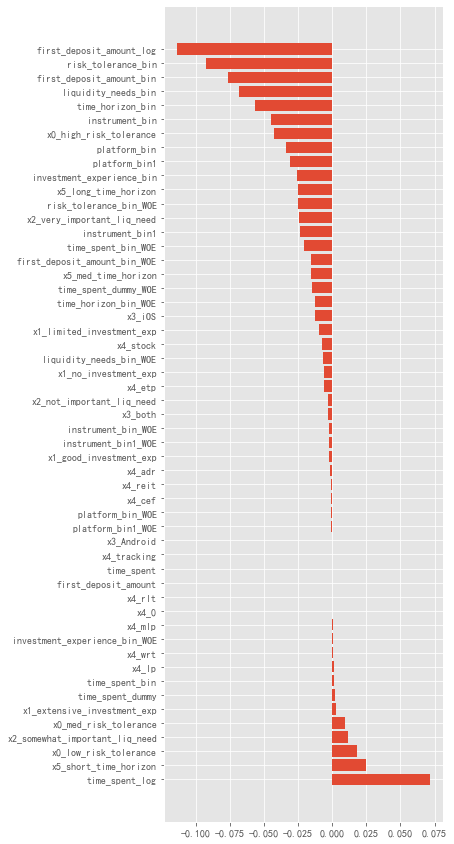

In [42]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.001, fit_intercept=True,penalty='l2')
lr.fit(train_data, train_target)

df_coeffs= pd.DataFrame(list(zip(model_features1, lr.coef_.flatten()))).sort_values(by=[1],ascending=False)
df_coeffs.columns=["feature","coeff"]
print(df_coeffs)
f, ax = plt.subplots(figsize=(5,15))
plt.barh(y="feature", width = 'coeff',data=df_coeffs )
t = np.arange(train_data.shape[1])
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
plt.show()

#### Here we see the least 3 important variables from 8 variables are 
- investment experience
- platform
- instrument
- *time horizon is somewhat important*

##### Multicolinearity analysis

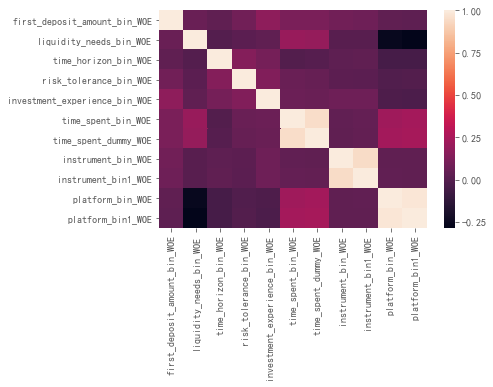

In [43]:
# correlation
WOE_var = ['first_deposit_amount_bin_WOE','liquidity_needs_bin_WOE', 'time_horizon_bin_WOE' ,\
           'risk_tolerance_bin_WOE', 'investment_experience_bin_WOE',\
           'time_spent_bin_WOE','time_spent_dummy_WOE',\
           'instrument_bin_WOE','instrument_bin1_WOE',\
           'platform_bin_WOE','platform_bin1_WOE']

X=train_data_reg[WOE_var]
 
    
corr = X.corr() 
# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)


In [44]:
# VIF Analysis
VIF_analysis = ['first_deposit_amount_bin_WOE','liquidity_needs_bin_WOE', 'time_horizon_bin_WOE' ,\
           'risk_tolerance_bin_WOE', 'investment_experience_bin_WOE',\
           'time_spent_bin_WOE', \
           'instrument_bin_WOE', \
           'platform_bin_WOE']
X_VIF=train_data_reg[VIF_analysis]
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF_list = [variance_inflation_factor(X_VIF.values, i) for i in range(X_VIF.shape[1])]
VIF_list

[1.060914786406334,
 1.1672095403807792,
 1.033041644789958,
 1.049840161335118,
 1.0618389840869196,
 1.168432807459685,
 1.0152577925113548,
 1.179293504056166]

#### There is no multicolinearity among the 8 variables 

### Coefficient estimation

In [45]:
import statsmodels.api as sm
multi_analysis = VIF_analysis
X = train_data_reg[multi_analysis]
X['intercept'] = [1] * X.shape[0]
y = train_data_reg['churn_flag']
logit = sm.Logit(y, X)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
print(fit_result.sort_values(by='p-value'))

Optimization terminated successfully.
         Current function value: 0.443676
         Iterations 6
                                   coef        p-value
intercept                     -1.512779  1.242417e-261
first_deposit_amount_bin_WOE  -0.876250   3.285028e-18
time_spent_bin_WOE            -0.791225   3.185311e-09
risk_tolerance_bin_WOE        -0.787916   1.345232e-07
time_horizon_bin_WOE          -0.862505   1.737919e-04
liquidity_needs_bin_WOE       -0.728657   2.915450e-03
platform_bin_WOE              -0.791379   1.231883e-01
instrument_bin_WOE            -0.574228   1.497613e-01
investment_experience_bin_WOE  0.268905   5.093905e-01


/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Remember for IV analysis we know 
- instrument 
- investment_experience 
- platform are not predictive

#### Remember for logistic regression with L2 norm regularization , we see the 3 least important variables from total 8 variables are
- investment experience
- platform
- instrument
- *time horizon is somewhat important*

#### Here we see from P value , the same three variables are not important
- investment_experience(p = 0.5)
- instrument (p = 0.1) 
- platform  (p = 0.1) 

In [46]:
'''
Here to use GBDT to search important variable for double checking
'''

X=train_data_reg[model_features1]
clf = ensemble.GradientBoostingClassifier()
gbdt_model = clf.fit(X, y)
importace = gbdt_model.feature_importances_.tolist()
featureImportance = zip(model_features1,importace)
featureImportanceSorted = sorted(featureImportance, key=lambda k: k[1],reverse=True)
featureImportanceSorted

[('time_spent_log', 0.1878282420455481),
 ('time_spent', 0.17596908251166565),
 ('first_deposit_amount', 0.1663081107916207),
 ('first_deposit_amount_log', 0.12902551541889373),
 ('x0_high_risk_tolerance', 0.037507011598937566),
 ('x0_low_risk_tolerance', 0.032709188198684465),
 ('risk_tolerance_bin', 0.020414329869288428),
 ('x5_short_time_horizon', 0.01942136331219094),
 ('time_spent_bin_WOE', 0.019282467595863786),
 ('x2_somewhat_important_liq_need', 0.018752304965432752),
 ('risk_tolerance_bin_WOE', 0.018718850853888545),
 ('time_horizon_bin_WOE', 0.015393422523312088),
 ('x4_lp', 0.014397773773828606),
 ('liquidity_needs_bin_WOE', 0.012979547144766328),
 ('x5_long_time_horizon', 0.011787414442303615),
 ('x4_stock', 0.011452074814658562),
 ('x4_mlp', 0.011037215478837396),
 ('x1_extensive_investment_exp', 0.010959674257121934),
 ('x1_limited_investment_exp', 0.007814490276981232),
 ('x5_med_time_horizon', 0.0072795693542262365),
 ('x4_reit', 0.00574225789103316),
 ('x4_adr', 0.0049

#### Remember for IV analysis we know 
- instrument 
- investment_experience 
- platform are not predictive

#### Remember for logistic regression with L2 norm regularization , we see the 3 least important variables from total 8 variables are
- investment experience
- platform
- instrument
- *time horizon is somewhat important*

#### Remember from P value for non-regularized logistic model, the same three variables are not important
- investment_experience(p = 0.5)
- instrument (p = 0.1) 
- platform  (p = 0.1) 

### Here from GBDT we confirm below two varaibles are not significant
- investment experience
- platform
- *instrument some level is important to some extent, but the sample size is low, so we cannot really tell*



#### let me exclude investment_experience and platform and re -run regression

In [47]:
import statsmodels.api as sm
multi_analysis1 = ['first_deposit_amount_bin_WOE','liquidity_needs_bin_WOE', \
           'risk_tolerance_bin_WOE', \
           'time_spent_bin_WOE', \
           'instrument_bin_WOE', \
           'time_horizon_bin_WOE']
X = train_data_reg[multi_analysis1]
X['intercept'] = [1] * X.shape[0]
y = train_data_reg['churn_flag']
logit = sm.Logit(y, X)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
print(fit_result.sort_values(by='p-value'))

Optimization terminated successfully.
         Current function value: 0.444043
         Iterations 6
                                  coef        p-value
intercept                    -1.512071  6.844592e-262
first_deposit_amount_bin_WOE -0.868042   2.575298e-18
time_spent_bin_WOE           -0.834578   1.262656e-10
risk_tolerance_bin_WOE       -0.772583   1.968646e-07
time_horizon_bin_WOE         -0.832286   2.708449e-04
liquidity_needs_bin_WOE      -0.591944   9.663862e-03
instrument_bin_WOE           -0.574936   1.483747e-01


/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Here we see  instrument (p = 0.1)
#### let me exclude instrument and re-run regression

In [48]:
import statsmodels.api as sm
multi_analysis2 = ['first_deposit_amount_bin_WOE', 'time_spent_bin_WOE', \
                      'risk_tolerance_bin_WOE', 'liquidity_needs_bin_WOE',  \
                      'time_horizon_bin_WOE'  ]
X = train_data_reg[multi_analysis2]
X['intercept'] = [1] * X.shape[0]
y = train_data_reg['churn_flag']
logit = sm.Logit(y, X)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
print(fit_result.sort_values(by='p-value'))

Optimization terminated successfully.
         Current function value: 0.444322
         Iterations 6
                                  coef        p-value
intercept                    -1.511981  3.765492e-262
first_deposit_amount_bin_WOE -0.878813   8.014617e-19
time_spent_bin_WOE           -0.838877   9.932031e-11
risk_tolerance_bin_WOE       -0.775073   1.777825e-07
time_horizon_bin_WOE         -0.838410   2.426044e-04
liquidity_needs_bin_WOE      -0.591408   9.707269e-03


/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Remember for IV analysis we know 
- instrument 
- investment_experience 
- platform are not predictive

#### Remember for logistic regression with L2 norm regularization , we see the 3 least important variables from total 8 variables are
- investment experience
- platform
- instrument
- *time horizon is somewhat important*

#### Remember from P value for non-regularized logistic model, the same three variables are not important
- investment_experience(p = 0.5)
- instrument (p = 0.1) 
- platform  (p = 0.1) 

#### Remember from GBDT we confirm below two varaibles are not significant
- investment experience
- platform
- *instrument some level is important to some extent, but the sample size is low, so we cannot really tell*

#### Here from regression I furthur delete due to large p value
- instrument

#### I confirm all the rest variables are important and significant  
- first_deposit_amount 
- risk_tolerance 
- time_spent_bin 
- liquidity_needs 
- time horizon

 

In [49]:
import statsmodels.api as sm
multi_analysis_final = ['first_deposit_amount_bin_WOE', 'time_spent_bin_WOE', \
                      'risk_tolerance_bin_WOE', 'liquidity_needs_bin_WOE','time_horizon_bin_WOE' ]
X = train_data_reg[multi_analysis_final]
X['intercept'] = [1] * X.shape[0]
y = train_data_reg['churn_flag']
logit = sm.Logit(y, X)
logit_result = logit.fit()
pvalues = logit_result.pvalues
params = logit_result.params
fit_result = pd.concat([params,pvalues],axis=1)
fit_result.columns = ['coef','p-value']
print(fit_result.sort_values(by='p-value'))

Optimization terminated successfully.
         Current function value: 0.444322
         Iterations 6
                                  coef        p-value
intercept                    -1.511981  3.765492e-262
first_deposit_amount_bin_WOE -0.878813   8.014617e-19
time_spent_bin_WOE           -0.838877   9.932031e-11
risk_tolerance_bin_WOE       -0.775073   1.777825e-07
time_horizon_bin_WOE         -0.838410   2.426044e-04
liquidity_needs_bin_WOE      -0.591408   9.707269e-03


/Users/makun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Scoring

In [50]:
finalFeatures=multi_analysis_final
coef_dict = params.to_dict()
print(coef_dict)
def Predict_LR(x, var_list, coef_dict, prob=True):
    '''
    :param x: WOE var
    :param var_list: finalFeatures
    :param coef_dict:  coef_dict list
    :param prob: if probability is needed，prob=True. Default value is False, for returning log odds
    :return: 
    '''
    s = coef_dict['intercept']
    for var in var_list:
        s += x[var]*coef_dict[var]
    if prob == True:
        y = 1.0/(1+np.exp(-s))
        return y
    else:
        return s
train_data_reg['probability'] = train_data_reg.apply(lambda x: Predict_LR(x, finalFeatures, coef_dict),axis=1)
print('Train KS = %6.4f' %KS(train_data_reg, 'probability', 'churn_flag')) 


{'first_deposit_amount_bin_WOE': -0.8788131703303984, 'time_spent_bin_WOE': -0.8388767682264132, 'risk_tolerance_bin_WOE': -0.7750731703165817, 'liquidity_needs_bin_WOE': -0.5914077692315493, 'time_horizon_bin_WOE': -0.8384101352009536, 'intercept': -1.511981233530129}
Train KS = 0.2670


#### Scoring in test dataset

In [51]:
for pair in  [(k,v['IV']) for k,v in WOE_IV_dict.items() ]:
    var=pair[0]
    newVar = var+"_WOE"
    test_data_reg[newVar] = test_data_reg[var].map(lambda x: WOE_IV_dict[var]['WOE'][x])



test_data_reg['probability'] = test_data_reg.apply(lambda x: Predict_LR(x, finalFeatures, coef_dict),axis=1)
print('Test KS = %6.4f' %KS(test_data_reg, 'probability', 'churn_flag'))

Test KS = 0.2970


In [52]:
### Calculate the KS  
def KS_Table(df, score, target):
    '''
    :param df: the dataset containing probability and bad indicator
    :param score:
    :param target:
    :return:
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all.index = range(len(all))
    all = all.sort_values(by=score,ascending=False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    all['totalCumRate'] = all['total'].cumsum() / all['total'].sum() 
    all['badCum'] = all['bad'].cumsum()  
    all['totalCum'] = all['total'].cumsum()  
    KS = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    all["ks"] = KS
    return all


In [53]:
train_KS_table = KS_Table(train_data_reg, 'probability', 'churn_flag')
train_KS_table[abs(train_KS_table['badCum'] -train_data_reg.churn_flag.sum())<=1 ]


,total,bad,good,probability,badCumRate,goodCumRate,totalCumRate,badCum,totalCum,ks
337,2,1,1,0.036040,0.998586,0.99875,0.998721,706,3903,-0.000165
338,5,1,4,0.026446,1.000000,1.00000,1.000000,707,3908,0.000000


In [54]:
train_KS_table[train_KS_table['ks'] ==KS(train_data_reg, 'probability', 'churn_flag')]
best_cutoff = train_KS_table[train_KS_table['ks'] ==KS(train_data_reg, 'probability', 'churn_flag')].probability.iloc[0]
best_cutoff

0.2041293636077731

In [55]:
test_KS_table = KS_Table(test_data_reg, 'probability', 'churn_flag')
test_KS_table[test_KS_table['ks'] ==KS(test_data_reg, 'probability', 'churn_flag')]


,total,bad,good,probability,badCumRate,goodCumRate,totalCumRate,badCum,totalCum,ks
163,6,3,3,0.186406,0.68,0.382994,0.436158,204,731,0.297006


In [56]:
print(test_KS_table[test_KS_table['probability'] ==best_cutoff])

     total  bad  good  probability  badCumRate  goodCumRate  totalCumRate  \
144      2    0     2     0.204129    0.566667     0.321221      0.365155   

     badCum  totalCum        ks  
144     170       612  0.245446  


### I will use the probability which has maximum seperation KS

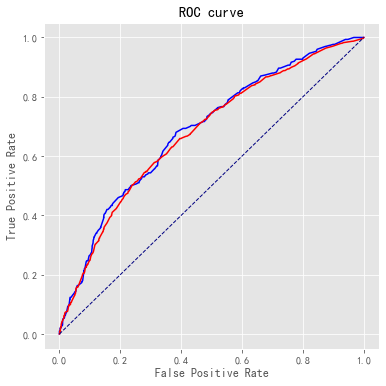

Train AUC = 0.6765
Test AUC = 0.6866
Train KS = 0.2670
Test KS = 0.2970
[[936 440]
 [130 170]]
              precision    recall  f1-score   support

           0       0.88      0.68      0.77      1376
           1       0.28      0.57      0.37       300

    accuracy                           0.66      1676
   macro avg       0.58      0.62      0.57      1676
weighted avg       0.77      0.66      0.70      1676



In [57]:
train_est = train_data_reg.probability.map(lambda x: 1 if x>best_cutoff else 0 )
train_est_p= train_data_reg.probability  
test_est= test_data_reg.probability.map(lambda x: 1 if x>best_cutoff  else 0 )
test_est_p=test_data_reg.probability  
 
fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_est_p)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_est_p)
plt.figure(figsize=[6,6])
plt.plot(fpr_test, tpr_test, color='blue')#blue :test
plt.plot(fpr_train, tpr_train, color='red')#red : train
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# no overfitting
print('Train AUC = %6.4f' %metrics.auc(fpr_train, tpr_train))  
print('Test AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))  
compare_train=pd.DataFrame({'train_target':train_target,'train_est':train_est,'train_est_p':train_est_p})
compare_test=pd.DataFrame({'test_target':test_target,'test_est':test_est,'test_est_p':test_est_p})
print('Train KS = %6.4f' %KS(compare_train, 'train_est_p', 'train_target')) 
print('Test KS = %6.4f' %KS(compare_test, 'test_est_p', 'test_target')) 

print(metrics.confusion_matrix(test_target, test_est,labels=[0,1]))  
print(metrics.classification_report(test_target, test_est))   
 

In [58]:
train_data_out=train_data_reg
train_data_out['churn_predict']=train_est
train_data_out =train_data_out[["churn_predict","probability"]].join(trainData["user_id"])

test_data_out=test_data_reg
test_data_out['churn_predict']=test_est
test_data_out =test_data_out[["churn_predict","probability"]].join(testData["user_id"])


train_data_out.to_csv('train_data_out.csv',index=False)
test_data_out.to_csv('test_data_out.csv',index=False)